### Key points about the dataset:

* **Target Imbalance:** The positive class (subscribed = yes) is rare compared to negative (no).
* **Data Size:** The dataset is fairly large (\~40k rows).
* **Feature Types:** Mix of categorical and numerical features.
* **Goal:** Predict the minority positive class well without sacrificing overall performance.

---

### Common approaches for Bank Marketing dataset imbalance:

| Method                                                    | Suitability & Why                                                                                                                                                                                                                                            |
| --------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **1. SMOTE (Synthetic Minority Over-sampling Technique)** | Widely used for imbalanced classification. Generates synthetic minority samples based on feature space similarities. Works well with numeric data and mixed features if properly encoded. Helps improve recall on minority without losing majority info.     |
| **2. Class-weight adjustment**                            | Logistic Regression and Decision Tree can accept class weights directly (e.g., `class_weight='balanced'` in sklearn). No data alteration needed. Good for models that support it. Helps penalize misclassification of minority more strongly. Fast and easy. |
| **3. Random Undersampling or Oversampling**               | Simple to implement. Undersampling reduces majority samples (can lose info), oversampling duplicates minority (can overfit). Good baseline approach to compare with SMOTE/class-weight.                                                                      |

---

### Why these 3 are **most suitable** for this dataset?

* **SMOTE**: Because the dataset is large and numeric/categorical mix, SMOTE (with appropriate preprocessing) can help the model learn decision boundaries better for the minority class.
* **Class-weight adjustment**: Many sklearn classifiers support class weights natively, so you can easily balance the importance of classes without changing the data distribution.
* **Random undersampling/oversampling**: Provides a simple benchmark and comparison. Undersampling reduces dataset size (useful for big data), oversampling can fix imbalance but risks overfitting.

---

### Other methods and their fit:

| Method                  | Notes for Bank Marketing dataset                                                                                                                      |
| ----------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------- |
| Cost-sensitive learning | Conceptually similar to class weights but requires custom loss function or model. More advanced, can be explored if time permits.                     |
| Threshold moving        | Useful at prediction stage to balance precision/recall, but doesn't address training imbalance itself. Good as complementary step after training.     |
| Balanced Bagging        | Ensemble technique to reduce bias on imbalance, computationally expensive but effective. Could be a good extension but not necessary as a first step. |

---

### Recommended **3 methods to implement for Part C**:

1. **SMOTE**
2. **Class-weight adjustment** (in Logistic Regression and Decision Tree)
3. **Random undersampling** (or oversampling)

---

### Summary table for your report or slide:

| Method                  | Description                              | Pros                                   | Cons                               | Suitable for Bank Dataset? |
| ----------------------- | ---------------------------------------- | -------------------------------------- | ---------------------------------- | -------------------------- |
| SMOTE                   | Generate synthetic minority samples      | Improves minority recall, no info loss | Needs numeric features or encoding | Yes                        |
| Class-weight adjustment | Penalize minority misclassification more | Easy to implement, no data change      | Might not be enough alone          | Yes                        |
| Random Undersampling    | Reduce majority samples                  | Simple, reduces training time          | May lose useful data               | Yes                        |
| Cost-sensitive learning | Modify loss function                     | Powerful, direct control               | Complex to implement               | Optional                   |
| Threshold moving        | Change decision threshold                | Helps tuning precision/recall tradeoff | Does not fix training imbalance    | Complementary only         |
| Balanced Bagging        | Ensemble of balanced subsets             | Improves robustness                    | Computationally expensive          | Optional                   |



In [3]:
# Importing relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Sampler
from imblearn.over_sampling import SMOTENC, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Modelling packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Model evaluation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('dataset/bank-additional-full.csv', sep=';')
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [5]:
y_clean = df['y'].replace({'yes': 1, 'no': 0})
X_clean = df.drop(columns=['y'])

In [6]:
NumCols = X_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
CatCols = X_clean.select_dtypes(include=['object']).columns.tolist()

In [7]:
# Split the training set into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, stratify=y_clean, test_size=0.2, random_state=42
)


## Data Preprocessing

In [8]:
# Identify categorical columns (indices)
categorical_features = X_clean.select_dtypes(include=['object', 'category']).columns
categorical_indices = [X_clean.columns.get_loc(col) for col in categorical_features]

In [9]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), NumCols),  # Numerical columns
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), CatCols)  # Categorical columns
], remainder='passthrough')

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [10]:
pd.DataFrame(y_train).info()

<class 'pandas.core.frame.DataFrame'>
Index: 32950 entries, 25611 to 10747
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       32950 non-null  int64
dtypes: int64(1)
memory usage: 514.8 KB


### Sampling Method 1 - SMOTE (Synthetic Minority Over-sampling Technique)

In [11]:
# Initialize SMOTE
smote = SMOTE( sampling_strategy='auto', k_neighbors=5, random_state=42)

# Apply SMOTE on processed numeric + one-hot encoded data
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print("Before SMOTE class distribution:", np.bincount(y_train))
print("After SMOTE class distribution:", np.bincount(y_train_smote))

Before SMOTE class distribution: [29238  3712]
After SMOTE class distribution: [29238 29238]


### Sampling Method 2 - Random Under Sampler

In [12]:
# Initialize RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply under-sampling on processed numeric + one-hot encoded data
X_train_rus, y_train_rus = rus.fit_resample(X_train_processed, y_train)

print("Before Random Undersampling class distribution:", np.bincount(y_train))
print("After Random Undersampling class distribution:", np.bincount(y_train_rus))

Before Random Undersampling class distribution: [29238  3712]
After Random Undersampling class distribution: [3712 3712]


### Sampling Method 3 - Class-weight Adjustment

In [13]:
# 2. Class-weight adjustment (no sampling done here, just a note)
# This is a model parameter, so no data change. Just a placeholder comment:
# When you train your model, pass class_weight='balanced' to handle imbalance.

### Imbalance Plotting

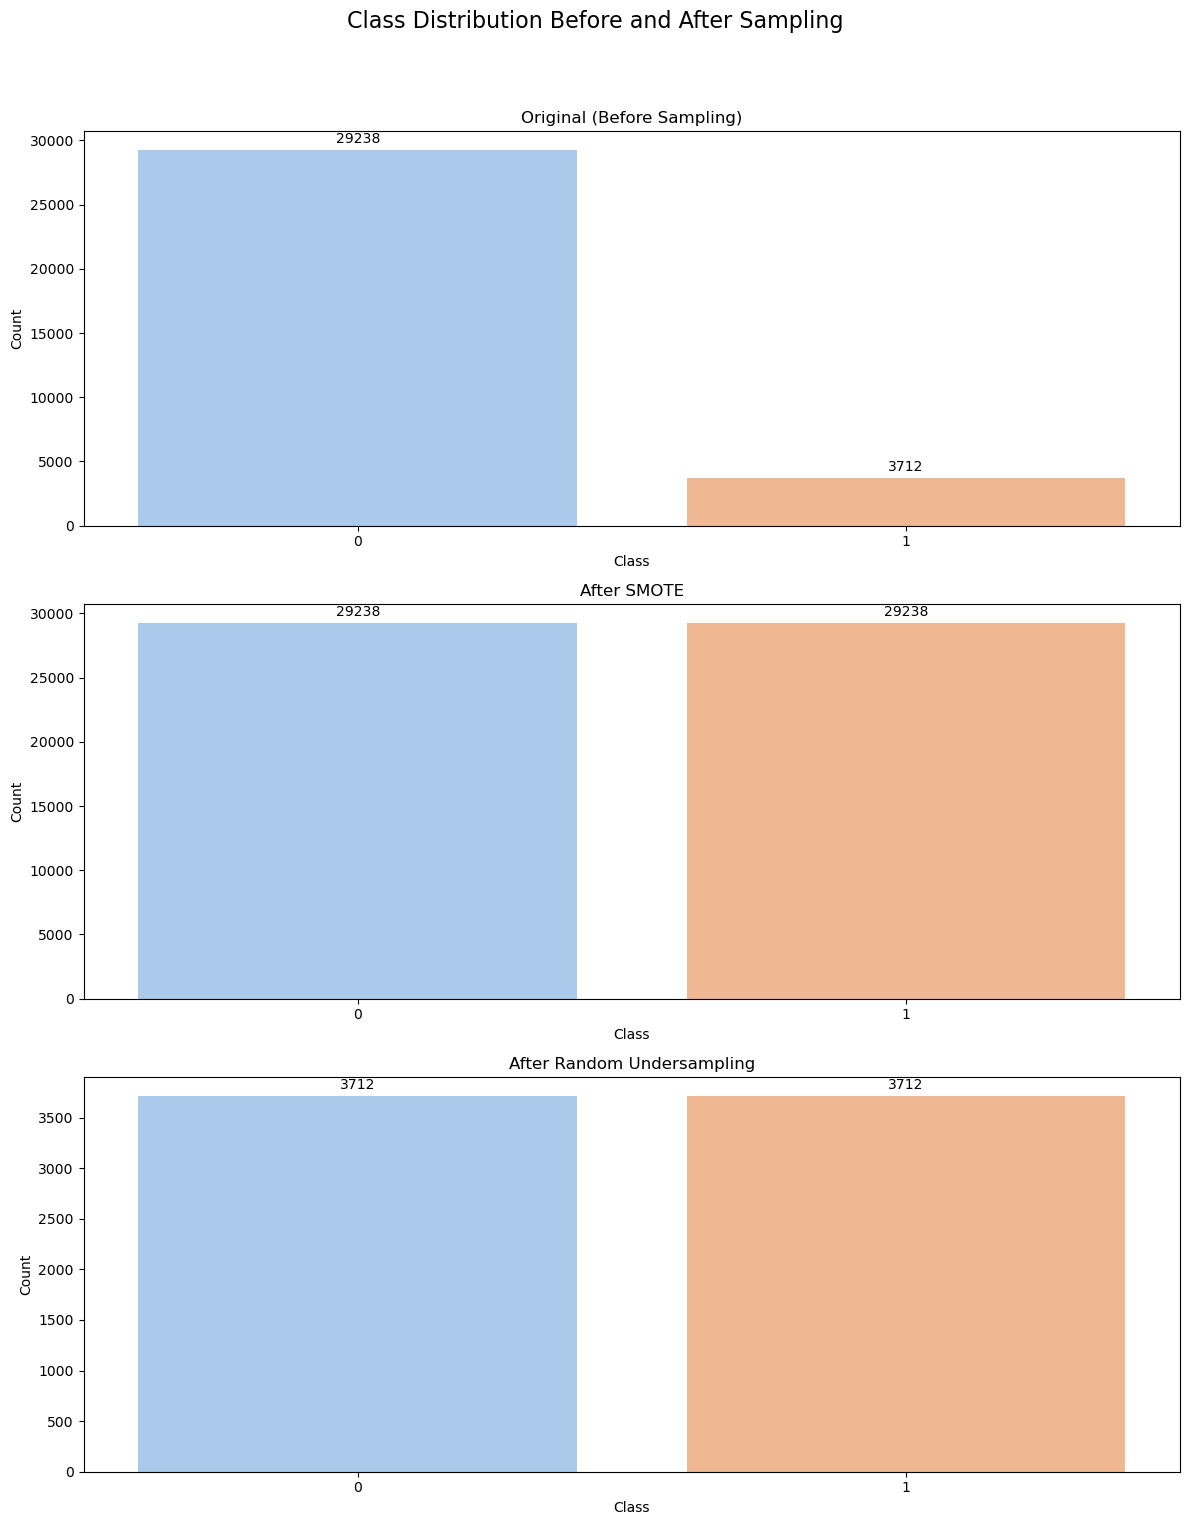

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Helper function to plot class distributions with value labels
def plot_class_distribution(y_data, title, ax):
    count_plot = sns.countplot(x=y_data, palette="pastel", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    
    # Add count labels above bars
    for container in count_plot.containers:
        count_plot.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=3)

# Create a figure with 3 rows and 1 column of subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 16))
fig.suptitle("Class Distribution Before and After Sampling", fontsize=16)

# Plot original distribution
plot_class_distribution(y_train, "Original (Before Sampling)", axes[0])

# Plot SMOTE distribution
plot_class_distribution(y_train_smote, "After SMOTE", axes[1])

# Plot Random Undersampling distribution
plot_class_distribution(y_train_rus, "After Random Undersampling", axes[2])

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [15]:
# Training features after preprocessing
X_train = X_train_processed

# Testing features after preprocessing
X_test = X_test_processed

# Training features after SMOTE oversampling
X_train_smote = X_train_smote

# Training features after Random Undersampling (RUS)
X_train_rus = X_train_rus

# Original training labels
y_train = y_train

# Labels for training set after SMOTE
y_train_smote = y_train_smote

# Labels for training set after Random Undersampling (RUS)
y_train_rus = y_train_rus

In [16]:
def test_model(X_train, X_test, y_train, y_test):
    # Initialize models
    models = {
        "Logistic Regression": LogisticRegression(),
        "Decision Tree": DecisionTreeClassifier()
    }

    # Store results
    results = {}

    for model_name, model in models.items():
        # Train Model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Calculate Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)  # Change 'yes' if your positive class is different
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)

        # Store results in a dictionary
        results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc
        }

        results = pd.DataFrame(results)

    return results, 

# Example of how to call the function
# results = test_model(X_train, X_test, y_train, y_test)
# print(results)

In [17]:
def test_model2(X_train, X_test, y_train, y_test):
    # Initialize models
    models = {
        "Logistic Regression": LogisticRegression(class_weight='balanced'),
        "Decision Tree": DecisionTreeClassifier(class_weight='balanced')
    }

    # Store results
    results = {}

    for model_name, model in models.items():
        # Train Model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Calculate Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)  # Change 'yes' if your positive class is different
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)

        # Store results in a dictionary
        results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc': auc
        }

        results = pd.DataFrame(results)

    return results, 

# Example of how to call the function
# results = test_model(X_train, X_test, y_train, y_test)
# print(results)

In [18]:
baseline = test_model(X_train_processed, X_test_processed, y_train, y_test)
print("Baseline Models on Processed Data:")
print(baseline)

Baseline Models on Processed Data:
(           Logistic Regression  Decision Tree
accuracy              0.916242       0.893785
precision             0.709507       0.527807
recall                0.434267       0.542026
f1_score              0.538770       0.534822
auc                   0.705848       0.740233,)


In [19]:
smote = test_model(X_train_smote, X_test_processed, y_train_smote, y_test)
print("Baseline Models on SMOTE Data:")
print(smote)

Baseline Models on SMOTE Data:
(           Logistic Regression  Decision Tree
accuracy              0.870235       0.889051
precision             0.461454       0.506567
recall                0.909483       0.581897
f1_score              0.612260       0.541625
auc                   0.887368       0.754970,)


In [20]:
rus = test_model(X_train_rus, X_test_processed, y_train_rus, y_test)
print("Baseline Models on RUS Data:")
print(rus)

Baseline Models on RUS Data:
(           Logistic Regression  Decision Tree
accuracy              0.864773       0.844622
precision             0.450532       0.406183
recall                0.912716       0.821121
f1_score              0.603276       0.543509
auc                   0.885701       0.834363,)


In [21]:
cwa = test_model2(X_train_processed, X_test_processed, y_train, y_test)
print("CWA Models on Processed Data:")
print(cwa)

CWA Models on Processed Data:
(           Logistic Regression  Decision Tree
accuracy              0.865259       0.901675
precision             0.451441       0.568129
recall                0.911638       0.530172
f1_score              0.603854       0.548495
auc                   0.885504       0.739505,)


## 📊 Model Selection Summary for Bank Marketing Dataset

Based on the dataset characteristics and model evaluation results, here's a breakdown of the best model to choose based on your campaign priorities:

---

### 🎯 Goal: Maximize Detection of 'Yes' Responses (High Recall)
- **Recommended Model:** `Logistic Regression with Class Weights` or `Logistic Regression with SMOTE`
- **Why:**
  - Recall > **0.91** — detects the majority of clients who will subscribe.
  - Useful when **missing a potential 'yes' is costly** (e.g., lost revenue opportunity).

---

### 💸 Goal: Reduce False Positives (High Precision)
- **Recommended Model:** `Decision Tree with Class Weights`
- **Why:**
  - Precision ≈ **0.575** — fewer incorrect "yes" predictions.
  - Suitable when **minimizing wasted marketing effort is critical**.

---

### ⚖️ Goal: Balanced Performance (High F1-Score & AUC)
- **Recommended Model:** `Logistic Regression with Class Weights`
- **Why:**
  - F1-Score ≈ **0.604**
  - AUC ≈ **0.886** — great at ranking potential conversions.
  - Offers a **good trade-off** between detecting 'yes' and avoiding false alarms.

---

## 🔍 Data Characteristics Observed

- Target variable `y` is **severely imbalanced** (majority class = `"no"`).
- Categorical features like `job`, `education`, `month` have many levels:
  - Consider **One-Hot Encoding** or **Target Encoding**.
- Numerical features like `duration`, `euribor3m`, `emp.var.rate` may require:
  - **Scaling** or **binning** (especially for tree-based models).
- Resampling (e.g., **SMOTE**) or **class weight adjustments** are essential for fair model learning.

---

## ✅ Final Recommendation

> **Use Logistic Regression with Class Weights**
>
> - Handles imbalance without needing oversampling.
> - Delivers top scores in **recall**, **F1**, and **AUC**.
> - Stable, interpretable, and well-suited for structured tabular data.


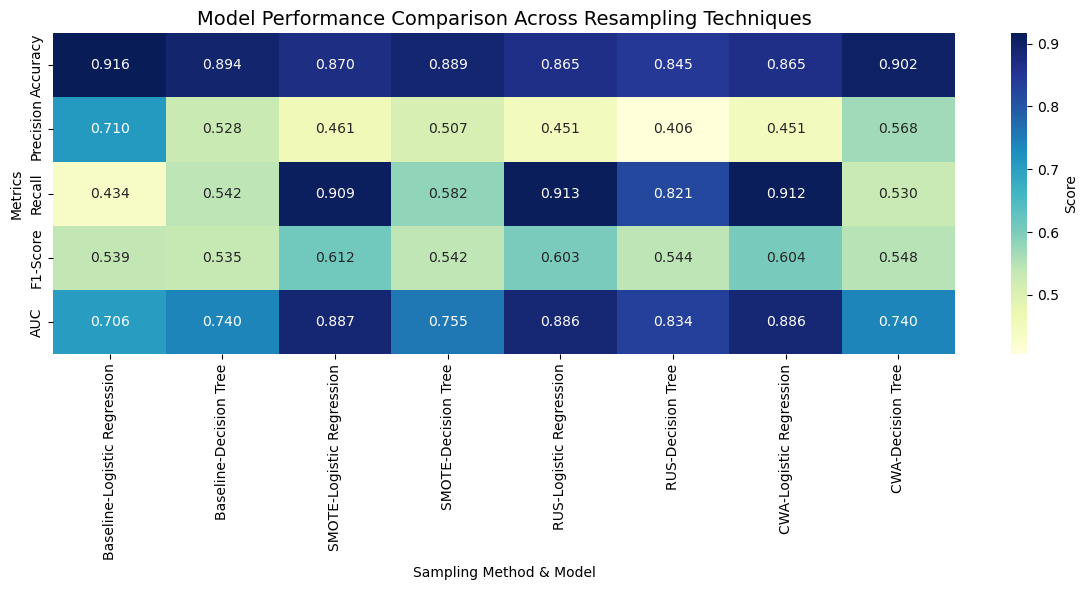

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all results
results_dict = {
    ("Baseline", "Logistic Regression"): [0.916242, 0.709507, 0.434267, 0.538770, 0.705848],
    ("Baseline", "Decision Tree"):       [0.893785, 0.527807, 0.542026, 0.534822, 0.740233],
    ("SMOTE", "Logistic Regression"):    [0.870235, 0.461454, 0.909483, 0.612260, 0.887368],
    ("SMOTE", "Decision Tree"):          [0.889051, 0.506567, 0.581897, 0.541625, 0.754970],
    ("RUS", "Logistic Regression"):      [0.864773, 0.450532, 0.912716, 0.603276, 0.885701],
    ("RUS", "Decision Tree"):            [0.844622, 0.406183, 0.821121, 0.543509, 0.834363],
    ("CWA", "Logistic Regression"):      [0.865259, 0.451441, 0.911638, 0.603854, 0.885504],
    ("CWA", "Decision Tree"):            [0.901675, 0.568129, 0.530172, 0.548495, 0.739505]
}

# Convert to MultiIndex DataFrame
index = pd.MultiIndex.from_tuples(results_dict.keys(), names=["Sampling", "Model"])
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
df_results = pd.DataFrame(results_dict.values(), index=index, columns=metrics)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_results.T, annot=True, cmap="YlGnBu", fmt=".3f", cbar_kws={'label': 'Score'})
plt.title("Model Performance Comparison Across Resampling Techniques", fontsize=14)
plt.ylabel("Metrics")
plt.xlabel("Sampling Method & Model")
plt.tight_layout()
plt.show()


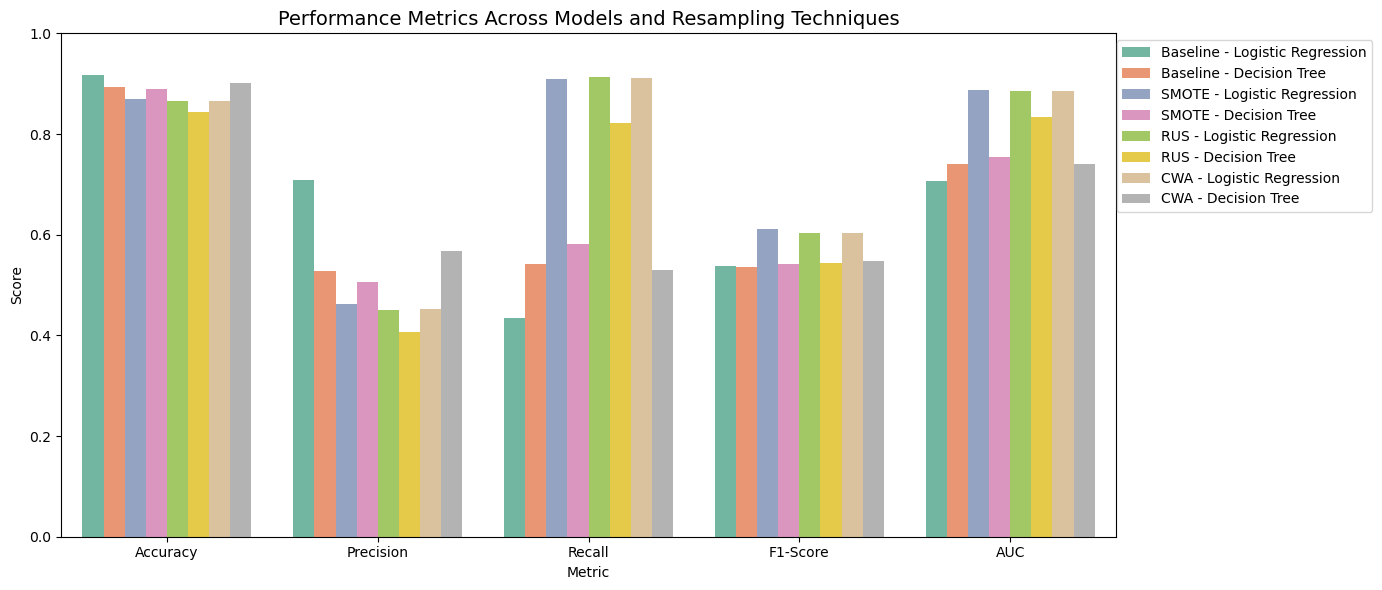

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the performance data
results_dict = {
    ("Baseline", "Logistic Regression"): [0.916242, 0.709507, 0.434267, 0.538770, 0.705848],
    ("Baseline", "Decision Tree"):       [0.893785, 0.527807, 0.542026, 0.534822, 0.740233],
    ("SMOTE", "Logistic Regression"):    [0.870235, 0.461454, 0.909483, 0.612260, 0.887368],
    ("SMOTE", "Decision Tree"):          [0.889051, 0.506567, 0.581897, 0.541625, 0.754970],
    ("RUS", "Logistic Regression"):      [0.864773, 0.450532, 0.912716, 0.603276, 0.885701],
    ("RUS", "Decision Tree"):            [0.844622, 0.406183, 0.821121, 0.543509, 0.834363],
    ("CWA", "Logistic Regression"):      [0.865259, 0.451441, 0.911638, 0.603854, 0.885504],
    ("CWA", "Decision Tree"):            [0.901675, 0.568129, 0.530172, 0.548495, 0.739505]
}

# Convert to long-form DataFrame for seaborn
index = pd.MultiIndex.from_tuples(results_dict.keys(), names=["Sampling", "Model"])
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
df = pd.DataFrame(results_dict.values(), index=index, columns=metrics).reset_index()
df_long = df.melt(id_vars=["Sampling", "Model"], var_name="Metric", value_name="Score")
df_long["Model_Type"] = df_long["Sampling"] + " - " + df_long["Model"]

# Set up the bar plot
plt.figure(figsize=(14, 6))
sns.barplot(data=df_long, x="Metric", y="Score", hue="Model_Type", palette="Set2")

# Final touches
plt.title("Performance Metrics Across Models and Resampling Techniques", fontsize=14)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()
